In [1]:
import numpy as np
import pandas as pd
import pickle

from news_text_clean import *

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Dropout
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils

# Fix random seed for reproducibility
np.random.seed(7) 
from tensorflow import set_random_seed
set_random_seed(2)

Using TensorFlow backend.


In [2]:
# Load the data
data1 = pd.read_json('data/manualVerified_senti_2600.json')

# Shuffle the data
data = data1.sample(frac=1,random_state=11).reset_index(drop=True)

# Clean the data
data = news_text_clean(data)

In [3]:
# USER INPUT
top_words = 10000 # Keep only the top 10000 frequently occuring words
max_words = 500 # Max words to consider in a given article
embed_dim = 32

# Preprocess the text (Convert words to numbers)
tokeniz = Tokenizer(num_words=top_words, split=' ')
tokeniz.fit_on_texts(data['contents'].values)

word_index = tokeniz.word_index
print('Total numbers of words in the dataset = ', len(word_index))

X_data = tokeniz.texts_to_sequences(data['contents'].values)
X_data = pad_sequences(X_data, maxlen=max_words, truncating='post')

# Negative, neutral & positive sentiments are -1, 0 & 1 in data. Convert it to 0, 1 & 2
y_data = data['Sentiment']+1 

# Split the data into train (90% of the data) and test data
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=0.9, random_state=1)

print('Counts of Negative, Neutral and Positive article =',np.unique(y_train,return_counts=True))

Y_train = np_utils.to_categorical(y_train, 3)
Y_test = np_utils.to_categorical(y_test, 3)

Total numbers of words in the dataset =  31332
Counts of Negative, Neutral and Positive article = (array([0, 1, 2]), array([ 475,  608, 1143]))


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [4]:
# Build the CNN model
model = Sequential()

model.add(Embedding(top_words, embed_dim, input_length=max_words))

model.add(Conv1D(filters=32, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=3))

model.add(Flatten())

model.add(Dense(64, activation='relu'))

model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

model.fit(X_train, Y_train, epochs=5, batch_size=64, validation_split=0.1, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           320000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 500, 32)           5152      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 166, 32)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5312)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                340032    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 665,379
Trainable params: 665,379
Non-trainable params: 0
_________________________________________________________________
None

Accuracy of the CNN is 63.7096774194 %
[[ 21  20   8]
 [  6  32  24]
 [  3  29 105]]


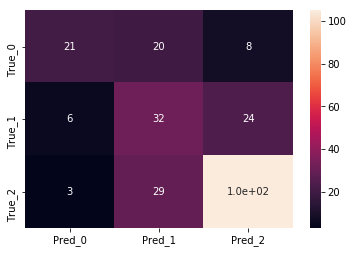

In [5]:
# Apply the model on the test set data
Y_prob = model.predict(X_test)
Y_class = np.argmax(Y_prob, axis=1)

scores = model.evaluate(X_test, Y_test, verbose=0)
print("Accuracy of the CNN is", scores[1]*100, "%")

# Calculate confusion matrix from sklearn
from sklearn.metrics import confusion_matrix
confu_mat = confusion_matrix(y_test, Y_class)

print(confu_mat)

# Create a Pandas dataframe for Seaborn
confu_df = pd.DataFrame(confu_mat, columns=['Pred_0','Pred_1','Pred_2'], index=['True_0','True_1','True_2'])

plt.figure
import seaborn as sn
sn.heatmap(confu_df, annot=True)
plt.show()


In [6]:
# Save the model and tokenizer
model.save('model_content_1.h5')
pickle.dump(tokeniz, open('tokenizer_content_1.p','wb'))

# Explanation
A Convolutional Neural Network (CNN) is trained using the labelled data in this 2nd Python script. In the first step, the labelled data containing 2500 articles from Coindesk website are imported and cleaned to remove numbers and other noises (refer "news_text_clean.py" script). Next, the words are tokenized (only the top 10000 frequently occuring words among the 2500 articles are kept in the vocabulary and only the first 500 words of an article are considered for the determination of sentiment). The data is split into traning (90%) and test set (10%), and 10% of the training set is used as the validation set. Finally, the CNN model is fit to the training data and is saved along with the tokenizer.

The accuracy of the CNN model on the validation set is around 70% and on the test set is around 65%. The confusion matrix of the test set shows that the negative and positive articles have been classified well. The CNN model seems to be confused while classifying neutral articles. To be honest, it was confusing for me to differentiate between the positive and neutral, and negative and neutral articles. I am not surprised that the CNN is also facing the same problem. Further optimization of the CNN architecture and bigger and better training data set could improve the accuracy of the CNN model.